# Analysis of our family group chat
My family has a really active group chat.  Rarely does a day pass that someone doesn't send a message.  Sometimes, I will lose service and return having missed 60+ messages.

With all that data, I thought it would be fun to learn a bit more about my family by looking at their messaging trends.

The family, from my parents to their grandchildren, is comprised of 22 individuals as seen below.  Only 9 of those are active on the group chat (marked in blue). I am the 2nd oldest.



<img src="files/img/FamilyTree.png">

# Imports and Load Data
I downloaded the data from GroupMe as a json file.  Behind the sense I replaced all the names and saved it as a pickle.

In [177]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
import emoji
import collections
from datetime import datetime
from textblob import TextBlob
%matplotlib inline

In [178]:
# open the file and create some time based columns

messages = pd.read_pickle('messages.pkl')
messages['created_at'] = pd.to_datetime(messages['created_at'], unit='s').dt.tz_localize(
    'UTC').dt.tz_convert('America/Los_Angeles')
messages['Date'] = messages['created_at'].dt.strftime('%Y-%m-%d')
messages['Hour'] = messages['created_at'].dt.strftime('%H')
messages['Time'] = messages['created_at'].dt.strftime('%r')

# The dataset
There are 24,240 messages from June, 2016 to March, 2020. That's almost 18 messages a day. 

The dataset includes all message contents, attachment links, messenger avatar links, date created, events (polls and things), who favorited what, the group id, message id, sender names, platform, sender id, sender type, something called source_guid, and if the message is a system message. Above, I created a date column (Y-M-D), an hour column (24-hour), and a time column (HH:MM:SS).

In [179]:
messages.columns

Index(['attachments', 'avatar_url', 'created_at', 'event', 'favorited_by',
       'group_id', 'id', 'name', 'platform', 'sender_id', 'sender_type',
       'source_guid', 'system', 'text', 'user_id', 'Date', 'Hour', 'Time'],
      dtype='object')

Next, I create a dataframe with each person's data summarized. Indexed by person, the columns are the number of messages, the number of attachments, the ratio of attachments to messages, number of favorites, favorites per message, Total number of words, words per message, the messages as a single string, the number of emojis, the emojis per message, and the favorite emojis. The dataframe is used to create the plots below.

In [235]:
df_dict = {}
s = " ~ "
for person, frame in messages.groupby('name'):
    headerlist = []

    df_dict[person] = []
    #number of messages
    df_dict[person].append(len(frame))
    headerlist.append('Number of Messages')
    
    #total words
    df_dict[person].append(int(frame['text'].str.split().str.len().sum()))
    headerlist.append('Total Words')
    
    #words per message
    df_dict[person].append(
        round(int(frame['text'].str.split().str.len().sum())/len(frame), 2))
    headerlist.append('Words per Message')
    
    #number of attachments
    df_dict[person].append(
        len(frame[frame['attachments'].apply(lambda c: c != [])]))
    headerlist.append('Number of Attachments')
    
    #percentage of attachments
    df_dict[person].append(round(
        len(frame[frame['attachments'].apply(lambda c: c != [])])/len(frame)*100, 2))
    headerlist.append('% Attachments')
    
    #number of favorites
    df_dict[person].append(frame['favorited_by'].str.len().sum())
    headerlist.append('Number of Favorites')
    
    #favorites per message
    df_dict[person].append(
        round(frame['favorited_by'].str.len().sum()/len(frame), 2))
    headerlist.append('Favorites per Message')

    txt=frame['text'].str.cat(sep=' ')
    emojis = ''.join(c for c in txt if c in emoji.UNICODE_EMOJI)
    fav_emojis = collections.Counter(emojis).most_common(5)
    fav_emoj_str = []
    fav_emoj_str.append(s.join([x[0] for x in fav_emojis]))
    
    #number of emojis
    df_dict[person].append(len(emojis))
    headerlist.append('Number of Emojis')

    #emojis per message
    df_dict[person].append(len(emojis)/len(frame))
    headerlist.append('Emojis per Message')

    #favorite emojis
    df_dict[person].append(fav_emoj_str)
    headerlist.append('Favorite Emojis')

    #messages
    df_dict[person].append(txt)
    headerlist.append('Messages')
    
person_df = pd.DataFrame.from_dict(df_dict, columns=headerlist, orient='index')
person_df.columns

Index(['Number of Messages', 'Total Words', 'Words per Message',
       'Number of Attachments', '% Attachments', 'Number of Favorites',
       'Favorites per Message', 'Number of Emojis', 'Emojis per Message',
       'Favorite Emojis', 'Messages'],
      dtype='object')

My older sister (1st, Daughter) sends a ton of messages, almost twice as much as the next person.  Most of the totals (total words, total attachments, etc) calculated above match the "Number of Messages" chart below so they've been skipped. Turns out my wife and the youngest are the wordiest.  Both of them haven't texted much but when they do, their texts tend to be about 10 words long on average.

The youngest's wife (5th's Wife) sends a lot of attachments and gets a lot of favorites.  We'll look at that a little closer later.  The younger kids also tend to send more attachments than the older.  I believe this is because their kids are still in that baby age where everything the baby does is documented and posted to social media, or in this case, our group chat. That being said, my parents don't lack for attachments either.

The 1st, Daughter, 3rd, Daughter, and 5th's Wife really like their emojis.  In fact, 3rd, Daughter and 5th's Wife sent more emojies than messages.  Others must not be fans. The men in the family all use emojis less than 12% of the time and 4th Daughter uses emojis only 2% of the time.  Maybe this is her way of being different than her two older sisters?

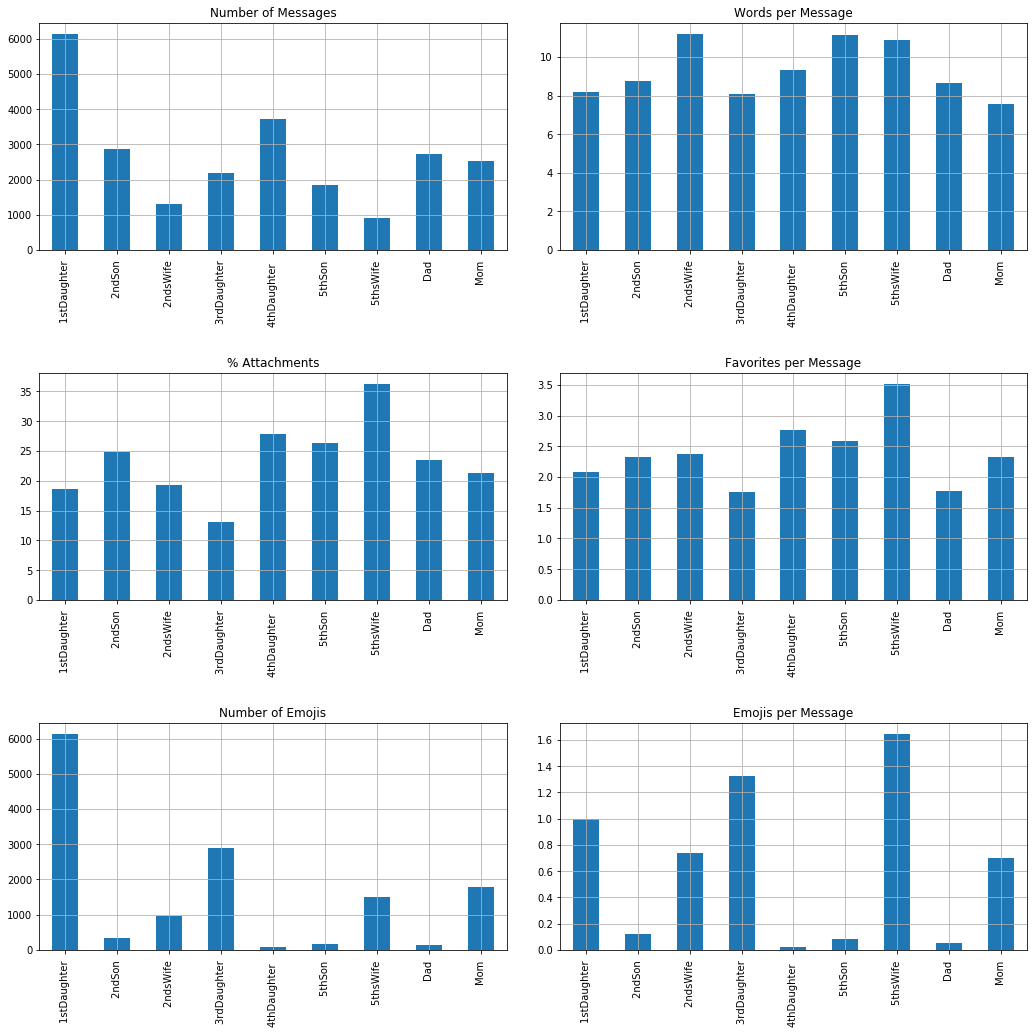

In [181]:
headerlist = ['Number of Messages', 'Words per Message', "% Attachments", 
              'Favorites per Message', 'Number of Emojis', 'Emojis per Message']

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

count = 0
for row in ax:
    for col in row:
        if count == len(headerlist):
            col.axis('off')
            break
        person_df[headerlist[count]].plot(kind='bar',
                                          grid=True,
                                          title=headerlist[count],
                                          ax=col)
        count += 1

fig.tight_layout(pad=3)

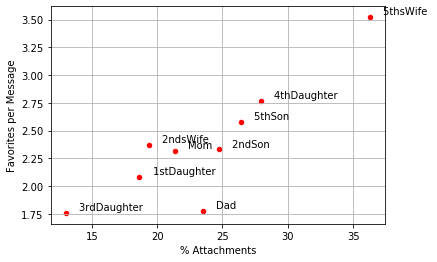

In [248]:
ax = person_df.plot.scatter(x='% Attachments',
                            y='Favorites per Message',
                            c='r', 
                            grid=True)

person_df = person_df.reset_index().rename(columns={'index':'Names'})

def label_point(x, y, val, ax):

    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)

    for i, point in a.iterrows():
        ax.text(point['x']+1, point['y']+.025, str(point['val']))

label_point(person_df['% Attachments'], person_df['Favorites per Message'], person_df['Names'], ax)
person_df = person_df.set_index('Names')
plt.show()

# Analysis of message contents per person

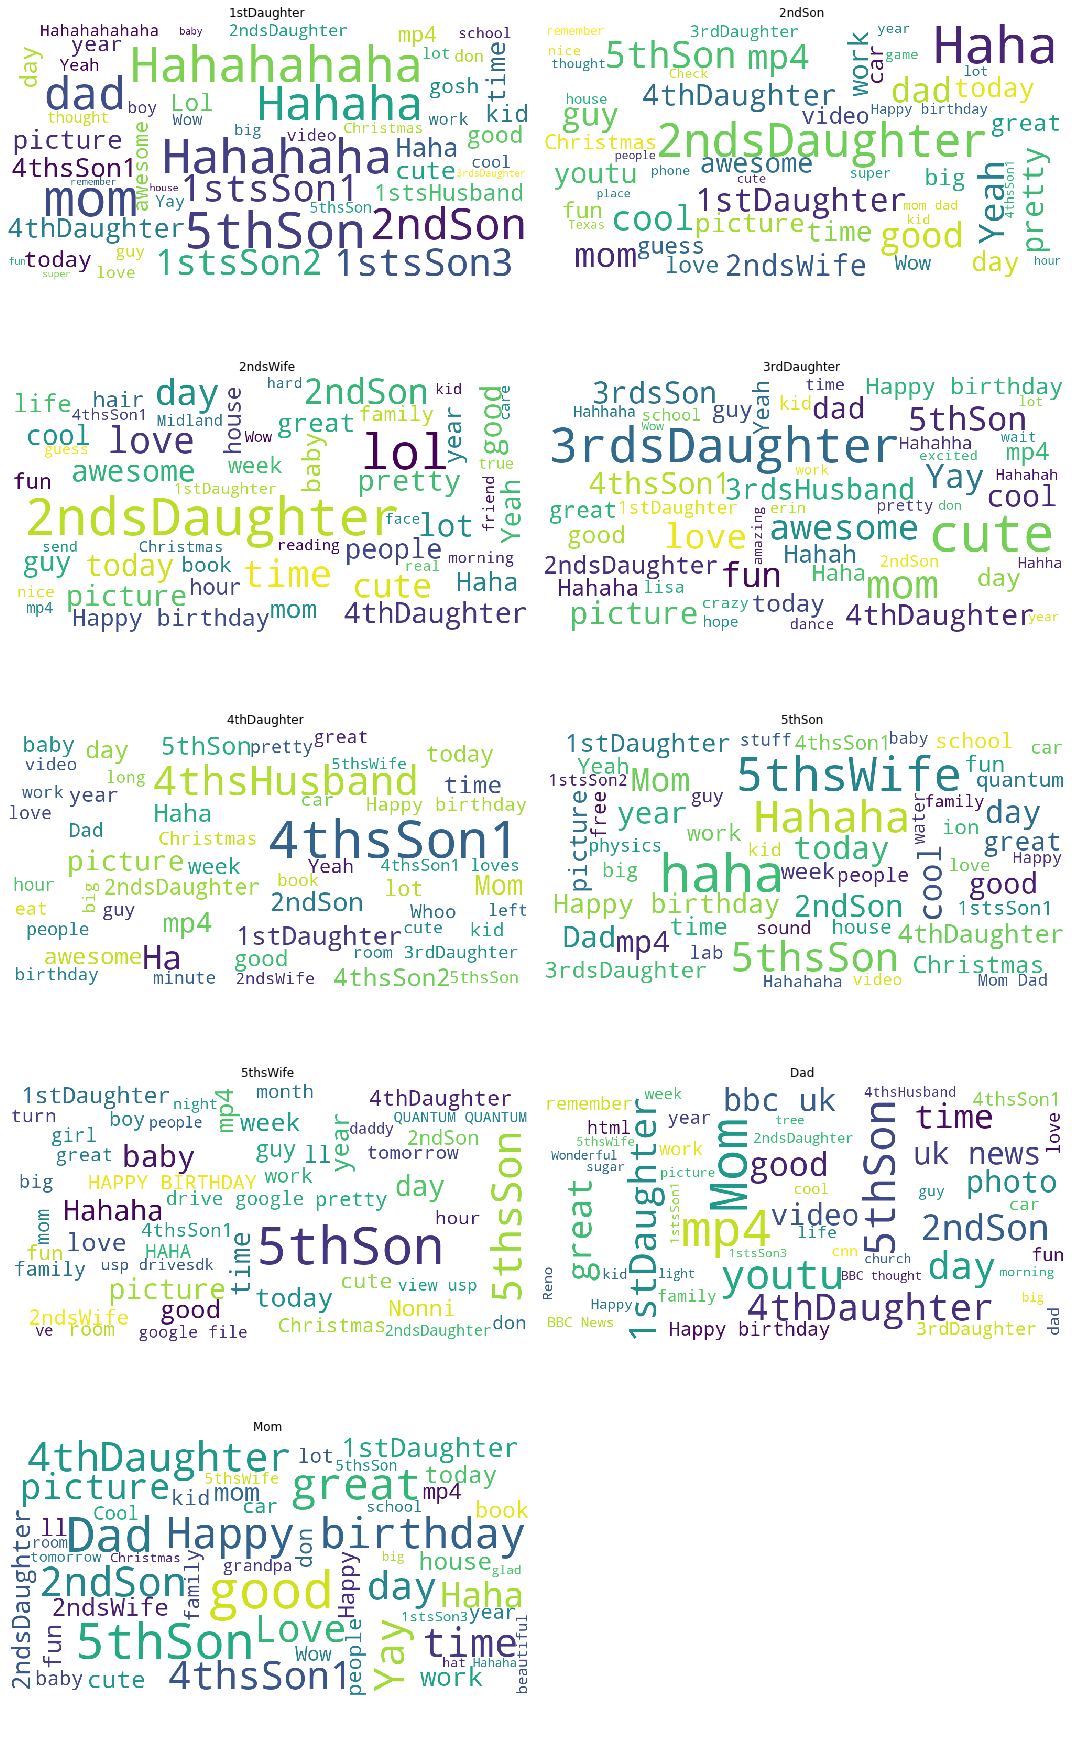

In [182]:
stopwords = set(line.strip() for line in open('stopwords1.txt'))
stopwords = stopwords.union(set(
    ['https', 'groupme', '640x360r90', '568x320r90', 'http', '640x360r', 'mp4https']))

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))

wordclouds = {}
for x in list(person_df.index):
    # Create and generate a word cloud image:
    wordclouds[x] = WordCloud(stopwords=stopwords,
                                width=1000,
                                height=500,
                                max_font_size=100,
                                max_words=50,
                                background_color="white").generate(person_df.loc[x]['Messages'])

# Display the generated image:
count=0
for row in ax:
    for col in row:
        col.axis('off')
        if count == len(wordclouds.keys()):
            break
        col.imshow(wordclouds[list(wordclouds.keys())[count]])
        col.title.set_text(list(wordclouds.keys())[count])
        count+=1  
        
fig.tight_layout()

# Analysis of messages through time

In [183]:
person_list = list(person_df.index)
df_dict = {}
for day, frame in messages.groupby('Date'):
    df_dict[day] = []
    df_dict[day].append(frame['id'].count())
    values = frame['name'].value_counts()
    for person in person_list:
        if person in list(values.index):
            df_dict[day].append(values.loc[person])
        else:
            df_dict[day].append(np.nan)

header_list = ['Message Count'] + person_list

day_df = pd.DataFrame.from_dict(df_dict, columns=header_list, orient='index')

In [184]:
month_df = day_df.reset_index()
month_df = month_df.rename(columns={'index': 'Date'})
month_df['Date'] = pd.to_datetime(month_df['Date'], format="%Y-%m-%d")
month_df = month_df.resample('M', on='Date').sum()
for column in list(month_df.columns)[1:]:
    month_df['% '+column] = round(month_df[column] /
                                  month_df['Message Count']*100, 2)

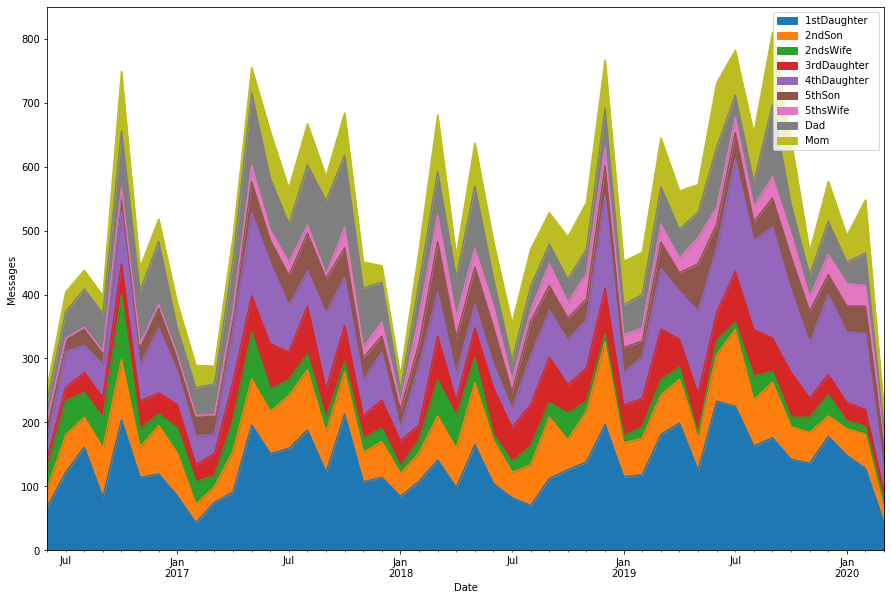

In [21]:
ax = month_df.plot.area(y=list(month_df.columns)[1:10], figsize=(15, 10))
ax.set_ylabel('Messages')
plt.show()

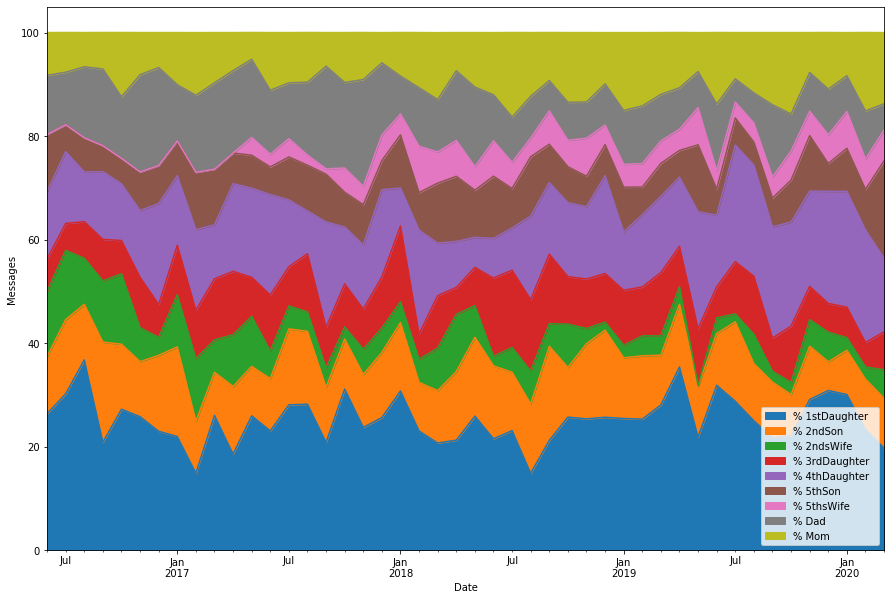

In [22]:
ax = month_df.plot.area(y=list(month_df.columns)[10:], figsize=(15, 10))
ax.set_ylabel('Messages')
plt.show()

In [23]:
person_list = list(person_df.index)
df_dict = {}
for day, frame in messages.groupby('Hour'):
    df_dict[day] = []
    df_dict[day].append(frame['id'].count())
    values = frame['name'].value_counts()
    for person in person_list:
        if person in list(values.index):
            df_dict[day].append(values.loc[person])
        else:
            df_dict[day].append(np.nan)

header_list = ['Message Count'] + person_list

hour_df = pd.DataFrame.from_dict(df_dict, columns=header_list, orient='index')

for column in list(hour_df.columns)[1:]:
    hour_df['% '+column] = round(hour_df[column] /
                                 hour_df['Message Count']*100, 2)

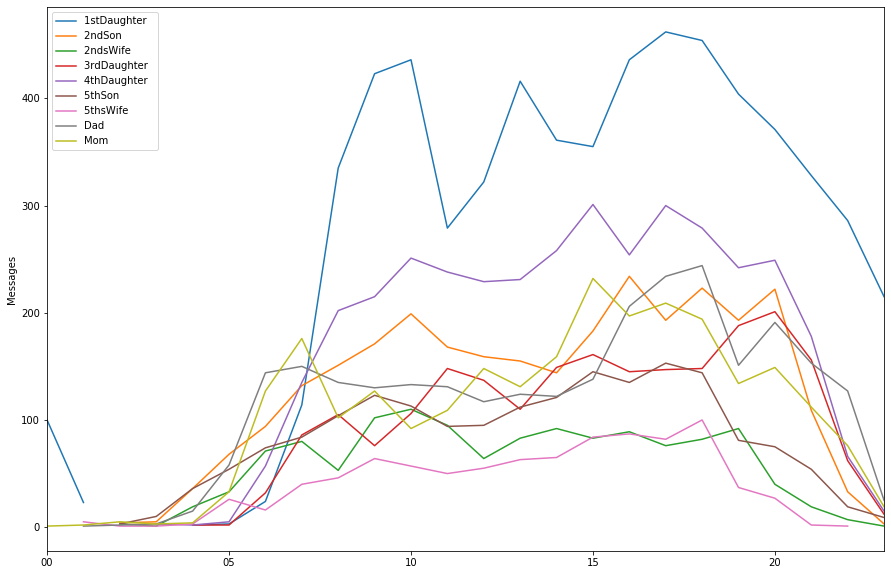

In [24]:
ax = hour_df.plot(y=list(hour_df.columns)[1:10], figsize=(15, 10))
ax.set_ylabel('Messages')
plt.show()

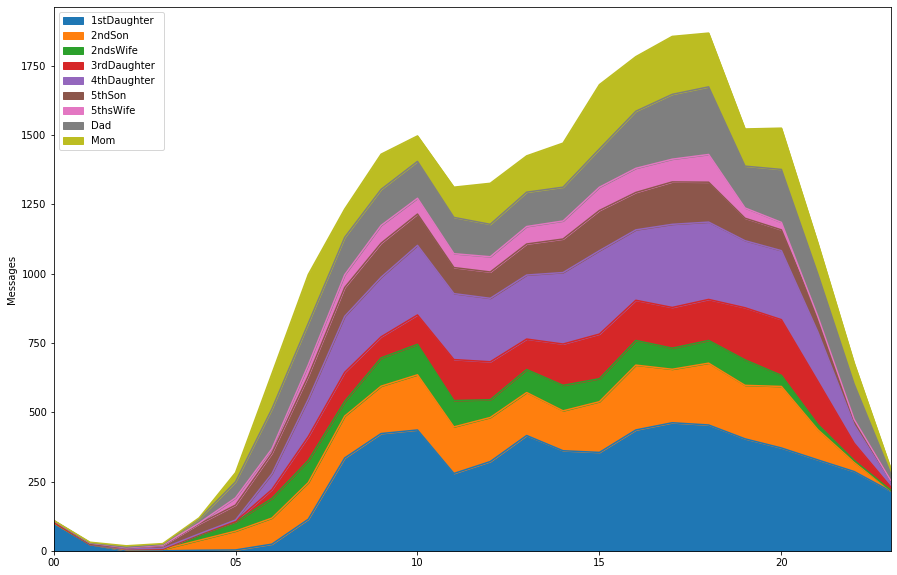

In [25]:
ax = hour_df.plot.area(y=list(hour_df.columns)[1:10], figsize=(15, 10))
ax.set_ylabel('Messages')
plt.show()

# Sentiment

In [26]:
def get_sentiment(message):
    if isinstance(message, str):
        analysis = TextBlob(message)
        if analysis.sentiment.polarity > 0:
            return 'positive'
        elif analysis.sentiment.polarity == 0:
            return 'neutral'
        else:
            return 'negative'
    else:
        return np.nan


messages['Sentiment'] = messages['text'].apply(get_sentiment)

In [27]:
df_dict = {}
for person, frame in messages.groupby('name'):
    df_dict[person] = []
    df_dict[person].append(
        round(frame['Sentiment'].value_counts()/len(frame)*100, 2)['positive'])
    df_dict[person].append(
        round(frame['Sentiment'].value_counts()/len(frame)*100, 2)['negative'])
    df_dict[person].append(
        round(frame['Sentiment'].value_counts()/len(frame)*100, 2)['neutral'])

header_list = ['% Positive', '% Negative', '% Neutral']

temp_df = pd.DataFrame.from_dict(df_dict, orient='index', columns=header_list)
person_df = pd.concat([person_df, temp_df], axis=1)

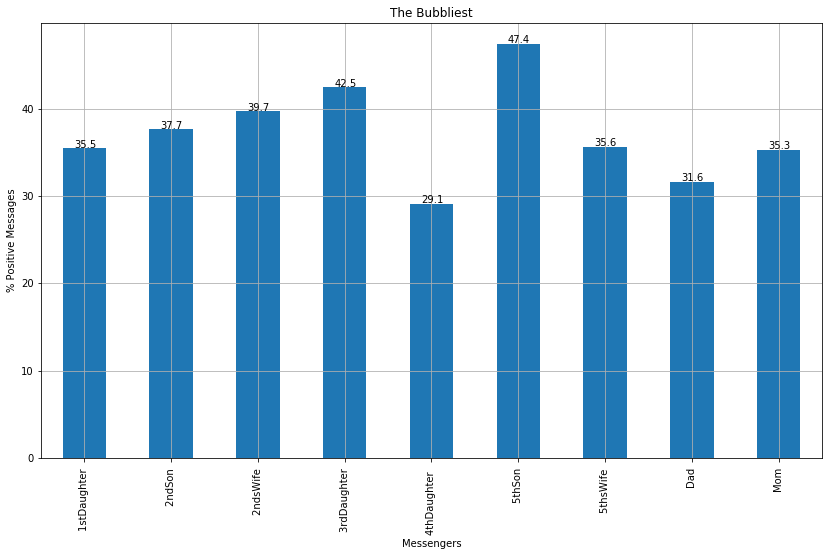

In [32]:
ax = person_df['% Positive'].plot(kind='bar',
                                  grid=True,
                                  figsize=(14, 8),
                                  title="The Bubbliest")
ax.set(xlabel="Messengers", ylabel="% Positive Messages")
for p in ax.patches:
    ax.annotate(round(p.get_height(), 1),
                (p.get_x() + .13, p.get_height() + .07))

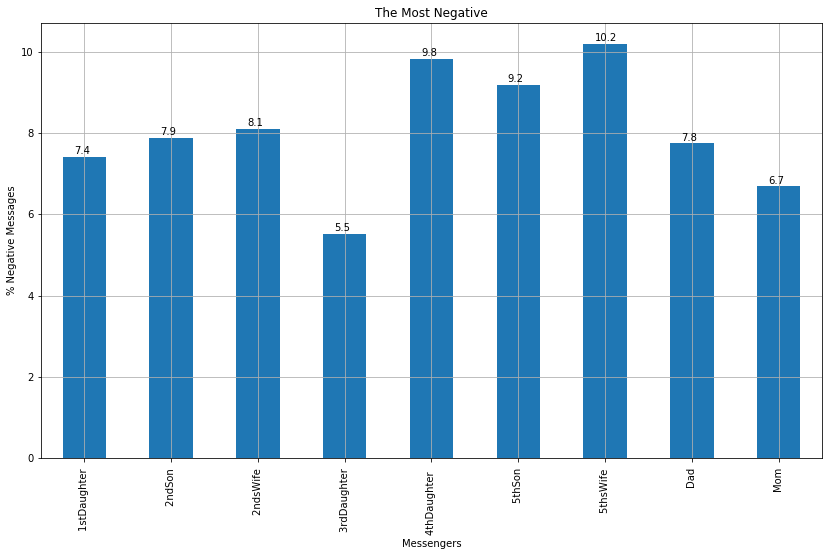

In [33]:
ax = person_df['% Negative'].plot(kind='bar',
                                  grid=True,
                                  figsize=(14, 8),
                                  title="The Most Negative")
ax.set(xlabel="Messengers", ylabel="% Negative Messages")
for p in ax.patches:
    ax.annotate(round(p.get_height(), 1),
                (p.get_x() + .13, p.get_height() + .07))

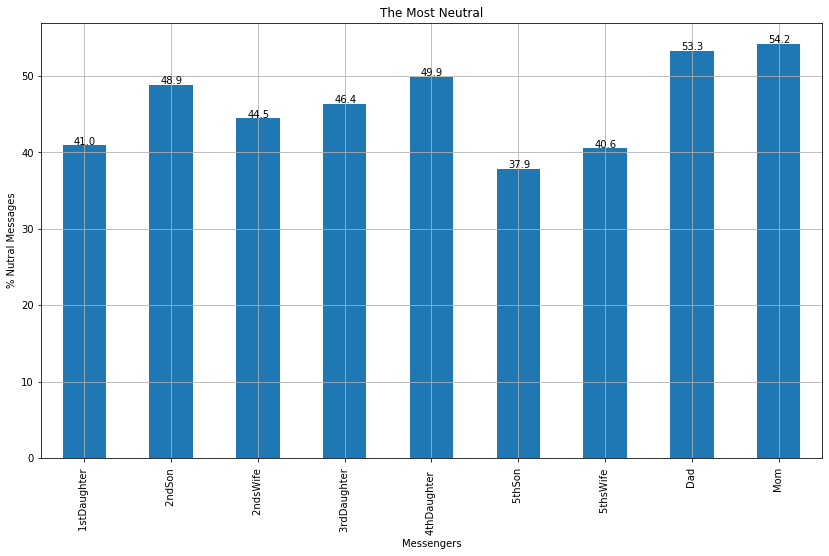

In [35]:
ax = person_df['% Neutral'].plot(kind='bar',
                                 grid=True,
                                 figsize=(14, 8),
                                 title="The Most Neutral")
ax.set(xlabel="Messengers", ylabel="% Nutral Messages")
for p in ax.patches:
    ax.annotate(round(p.get_height(), 1),
                (p.get_x() + .13, p.get_height() + .07))